<h1 id="title">Sampling at 2 x Minority Class Size, Testing on All the Data, Predicting Motor Vehicle Accident Severity in Seattle, Washington<\h1>

In [1]:
# Import packages and modules.
import io
import itertools
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import pylab as pl
import scipy
import scipy.optimize as opt
import seaborn as sns
import sklearn
import sys
import timeit
import warnings
from matplotlib.ticker import NullFormatter
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.sparse import csr_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.exceptions import ConvergenceWarning
from timeit import default_timer
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

In [3]:
# Define the starting time for this notebook. 
notebook_start_time = default_timer()

In [4]:
# This function computes the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def elapsed_time(start_time = notebook_start_time):
    return default_timer() - start_time   

In [5]:
# This function prints the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def print_elapsed_time(start_time = notebook_start_time):
    print("Elapsed time is", elapsed_time(start_time), "seconds.")
    return None

In [6]:
# Create a list of display options.
list_of_display_options_fully_qualified_names = str(\
"pd.options.display.chop_threshold, pd.options.display.float_format, pd.options.display.max_info_columns, pd.options.display.notebook_repr_html, \
pd.options.display.colheader_justify, pd.options.display.html, pd.options.display.max_info_rows, pd.options.display.pprint_nest_depth, \
pd.options.display.column_space, pd.options.display.large_repr, pd.options.display.max_rows, pd.options.display.precision, \
pd.options.display.date_dayfirst, pd.options.display.latex, pd.options.display.max_seq_items, pd.options.display.show_dimensions, \
pd.options.display.date_yearfirst, pd.options.display.max_categories, pd.options.display.memory_usage, pd.options.display.unicode, \
pd.options.display.encoding, pd.options.display.max_columns, pd.options.display.min_rows, pd.options.display.width, \
pd.options.display.expand_frame_repr, pd.options.display.max_colwidth, pd.options.display.multi_sparse").split(sep=', ')

# Initialize an empty list to store all the short names for display options.
list_of_display_options_short_names = list()
# For each fully qualified option name,
# get the option's short name and add it to the list of short names.
for fully_qualified_option_name in list_of_display_options_fully_qualified_names:
    # Get short option name.
    short_option_name = fully_qualified_option_name.split(sep='.')[-1]
    
    # Add short option name to list of display option short names.
    list_of_display_options_short_names.append(short_option_name)

# Define dictionary of display option settings.
dict_of_display_option_settings_short_names=\
{"max_info_columns": 1000,\
"colheader_justify": "right",\
"max_info_rows": 1000000,\
"column_space": 1000,\
"max_rows": 1000000,\
"precision": 9,\
"max_seq_items": 1000000000000,\
"show_dimensions": True,\
"max_categories": 100,\
"memory_usage": True,\
"max_columns": 1000,\
"max_colwidth": 1000,\
"float_format": lambda x: '%.9f' % x}

# Set pandas display options using dictionary of short names,
# and display the options/value pairs.
print("Setting display options...")
for key in list(dict_of_display_option_settings_short_names.keys()):
    # Set display option.
    pd.set_option(key, dict_of_display_option_settings_short_names[key])
    # Print display option name and value.
    print(key, ": ", pd.get_option(key), sep='')

Setting display options...
max_info_columns: 1000
colheader_justify: right
max_info_rows: 1000000
column_space: 1000
max_rows: 1000000
precision: 9
max_seq_items: 1000000000000
show_dimensions: True
max_categories: 100
memory_usage: True
max_columns: 1000
max_colwidth: 1000
float_format: <function <lambda> at 0x7f316cf68040>


In [7]:
# Set seed for random number generator.
# seed = np.int(os.times()[4]) # Use this line for better pseudo-random behavior.
seed = 42
print(seed)

42


In [8]:
# Attribute Information URL: https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf
# Read the Collisions Data CSV file and store it as a DataFrame.
# url="https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv" # HTTPError at 202009151050, using local copy of .csv instead.
# print(os.listdir("..")) # Print list of contents of current working directory.
local_path_to_csv = '~/IBM Data Science Professional Certificate Course/Course 9 - Applied Data Science Capstone/projects/Collisions.csv'
df=pd.read_csv(local_path_to_csv, low_memory=False)

In [9]:
# View the first few rows of the collisions DataFrame.
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.320757054,47.609407946,1,328476,329976,EA08706,Matched,Block,nan,BROADWAY BETWEEN E COLUMBIA ST AND BOYLSTON AVE,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020/01/22 00:00:00+00,1/22/2020 3:21:00 PM,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,N,Raining,Wet,Dark - Street Lights On,NaN,nan,NaN,11,From same direction - both going straight - both moving - sideswipe,0,0,N
1,-122.319560827,47.662220664,2,328142,329642,EA06882,Matched,Block,nan,8TH AVE NE BETWEEN NE 45TH E ST AND NE 47TH ST,,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2020/01/07 00:00:00+00,1/7/2020 8:00:00 AM,Mid-Block (not related to intersection),15.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE",NaN,N,Clear,Dry,Daylight,NaN,nan,NaN,32,One parked--one moving,0,0,Y
2,-122.327524508,47.604393273,3,20700,20700,1181833,Unmatched,Block,nan,JAMES ST BETWEEN 6TH AVE AND 7TH AVE,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/30 00:00:00+00,1/30/2004,Mid-Block (but intersection related),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,4030032.000000000,NaN,NaN,NaN,0,0,N
3,-122.327524934,47.708621579,4,332126,333626,M16001640,Unmatched,Block,nan,NE NORTHGATE WAY BETWEEN 1ST AVE NE AND NE NORTHGATE DR,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2016/01/23 00:00:00+00,1/23/2016,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N
4,-122.292120049,47.559009080,5,328238,329738,3857118,Unmatched,Block,nan,M L KING JR ER WAY S BETWEEN S ANGELINE ST AND S EDMUNDS ST,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2020/01/26 00:00:00+00,1/26/2020,Mid-Block (not related to intersection),28.000000000,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221389 entries, 0 to 221388
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                213918 non-null  float64
 1   Y                213918 non-null  float64
 2   OBJECTID         221389 non-null  int64  
 3   INCKEY           221389 non-null  int64  
 4   COLDETKEY        221389 non-null  int64  
 5   REPORTNO         221389 non-null  object 
 6   STATUS           221389 non-null  object 
 7   ADDRTYPE         217677 non-null  object 
 8   INTKEY           71884 non-null   float64
 9   LOCATION         216801 non-null  object 
 10  EXCEPTRSNCODE    100986 non-null  object 
 11  EXCEPTRSNDESC    11779 non-null   object 
 12  SEVERITYCODE     221388 non-null  object 
 13  SEVERITYDESC     221389 non-null  object 
 14  COLLISIONTYPE    195159 non-null  object 
 15  PERSONCOUNT      221389 non-null  int64  
 16  PEDCOUNT         221389 non-null  int6

In [11]:
print_elapsed_time(notebook_start_time)

Elapsed time is 9.860339079983532 seconds.


<h2 id="data_wrangling">Data Wrangling</h2>

Steps for working with missing data:
<ol>
    <li>Identify missing data.</li>
    <li>Deal with missing data.</li>
    <li>Correct data format.</li>
</ol>

<h3 id="identifying_missing_data">Identifying Missing Data</h3>

The metadata document that accompanied the data set indicates that certain columns have "sentinel" values
that indicate an unknown or missing value. Each of these missing values will first be converted into NaN.
Subsequently, the NaN values will be dropped from the DataFrame.

In [12]:
# If any row of the collisions DataFrame contains a sentinel value representing "unknown",
# then replace it with NaN. 
# Sentinels for "unknown" are listed in the metadata document that accompanies the dataset.
df_unknowns_converted_to_nan = df.replace(to_replace=\
{"EXCEPTRSNCODE": " ",\
 "EXCEPTRSNDESC": "Not Enough Information, or Insufficient Location Information",\
 "SEVERITYCODE": "0",\
 "SEVERITYDESC": "Unknown",\
 "JUNCTIONTYPE": "Unknown",\
 "WEATHER": "Unknown",\
 "ROADCOND": "Unknown",\
 "LIGHTCOND": "Unknown",\
 "SDOT_COLCODE": float(0),\
 "SDOT_COLDESC": "NOT ENOUGH INFORMATION / NOT APPLICABLE",\
 "ST_COLCODE": " ",\
 "ST_COLDESC": "Not stated"},\
value=np.nan, inplace=False, limit=None, regex=False, method='pad')

df_unknowns_converted_to_nan.replace(to_replace={"ST_COLCODE": "0", }, value=np.nan, inplace=True, limit=None, regex=False, method='pad')

In [13]:
print_elapsed_time(notebook_start_time)

Elapsed time is 16.899266132037155 seconds.


<h3 id="deal_with_missing_data">Deal with Missing Data</h3>

<ol>
    <li>Drop the Data
        <ol>
            <li>Drop entire row.</li>
            <li>Drop entire column.</li>
        </ol>
    </li>
    <li>Replace the Data
        <ol>
            <li>Replace data by mean.</li>
            <li>Replace data by frequency.</li>
            <li>Replace data based on other functions.</li>
        </ol>
    </li>
        
</ol>

Whole columns should be dropped only if most entries in the column are empty.

In [14]:
print(list(df.columns))

['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR']


In [15]:
# Drop any column from the collisions DataFrame if it satisfies at least one of the following conditions:
# 1) more than 15% of the column's data is NaN;
# 2) the column only contains unique identification keys, or information not useful for model building;
# 3) the column's data is categorical but does not fit into a small (< 15) number of categories;
# 4) information in the column is redundant because it is already represented by another column;
# 5) it is not clear how to interpret the column's data.
list_of_columns_to_drop = ["ADDRTYPE",\
                           "STATUS",\
                           "OBJECTID",\
                           "INCKEY",\
                           "COLDETKEY",\
                           "REPORTNO",\
                           "INTKEY",\
                           "LOCATION",\
                           "EXCEPTRSNCODE",\
                           "EXCEPTRSNDESC",\
                           "SEVERITYDESC",\
                           "INCDATE",\
                           "INCDTTM",\
                           "JUNCTIONTYPE",\
                           "SDOT_COLCODE",\
                           "SDOT_COLDESC",\
                           "INATTENTIONIND",\
                           "UNDERINFL",\
                           "PEDROWNOTGRNT",\
                           "SDOTCOLNUM",\
                           "SPEEDING",\
                           "ST_COLCODE",\
                           "ST_COLDESC",\
                           "SEGLANEKEY",\
                           "CROSSWALKKEY",\
                           "HITPARKEDCAR"]

In [16]:
# Drop the selected columns from the DataFrame after converting unknowns to NaN.
# Store the result in a new DataFrame.
df_drop_columns = df_unknowns_converted_to_nan.drop(columns=list_of_columns_to_drop, inplace=False)

In [17]:
# Drop any row that contains at least one NaN.
df_drop_columns_and_rows = df_drop_columns.dropna(axis="index", how="any", thresh=None, subset=None, inplace=False)

In [18]:
print_elapsed_time(notebook_start_time)

Elapsed time is 18.085071212030016 seconds.


<h3 id="correct_data_format">Correct Data Format</h3>

Ensure that each data type is appropriate for the corresponding feature.
Cast columns of type "object" as type "category", but leave all other column types unaltered.

In [19]:
# Create new DataFrame to store converted data types.
df_converted = pd.DataFrame()

for column in list(df_drop_columns_and_rows.columns):
    if (df_drop_columns_and_rows[column].dtype in [np.dtype('object')]):
        df_converted[column] = df_drop_columns_and_rows[column].astype('category')
    # Copy all other columns to new DataFrame without changing their types.
    else:
        df_converted[column] = df_drop_columns_and_rows[column]

In [20]:
# Create DataFrame of categorical or integer columns, inclusive.
df_categorical = df_converted.select_dtypes(include=["category", "integer"])

In [21]:
print_elapsed_time(notebook_start_time)

Elapsed time is 18.87978475098498 seconds.


<h2 id="feature_selection">Feature selection</h2>

#### Features before One-Hot Encoding

In [22]:
df_categorical.head()

,SEVERITYCODE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,WEATHER,ROADCOND,LIGHTCOND
0,1,Sideswipe,2,0,0,2,0,0,0,Raining,Wet,Dark - Street Lights On
1,1,Parked Car,2,0,0,2,0,0,0,Clear,Dry,Daylight
5,1,Rear Ended,2,0,0,2,0,0,0,Clear,Dry,Daylight
6,1,Other,2,0,0,1,0,0,0,Clear,Wet,Daylight
8,1,Sideswipe,2,0,0,2,0,0,0,Overcast,Dry,Daylight


In [23]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   SEVERITYCODE     171872 non-null  category
 1   COLLISIONTYPE    171872 non-null  category
 2   PERSONCOUNT      171872 non-null  int64   
 3   PEDCOUNT         171872 non-null  int64   
 4   PEDCYLCOUNT      171872 non-null  int64   
 5   VEHCOUNT         171872 non-null  int64   
 6   INJURIES         171872 non-null  int64   
 7   SERIOUSINJURIES  171872 non-null  int64   
 8   FATALITIES       171872 non-null  int64   
 9   WEATHER          171872 non-null  category
 10  ROADCOND         171872 non-null  category
 11  LIGHTCOND        171872 non-null  category
dtypes: category(5), int64(7)
memory usage: 11.3 MB


In [24]:
print_elapsed_time(notebook_start_time)

Elapsed time is 19.298346195020713 seconds.


<h2 id="imbalanced_data">Dealing with Imbalanced Data</h2>

Because the data is imbalanced, we split the DataFrame into four DataFrames, one for each value of the SEVERITYCODE feature.

In [25]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
1    0.657943120
2    0.323036911
2b   0.017111571
3    0.001908397
Name: SEVERITYCODE, Length: 4, dtype: float64


In [26]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
2      55521
2b      2941
3        328
Name: SEVERITYCODE, Length: 4, dtype: int64


In [27]:
df_class_1 = df_categorical[df_categorical['SEVERITYCODE'] == '1']
df_class_2 = df_categorical[df_categorical['SEVERITYCODE'] == '2']
df_class_2b = df_categorical[df_categorical['SEVERITYCODE'] == '2b']
df_class_3 = df_categorical[df_categorical['SEVERITYCODE'] == '3']

In [28]:
print("SEVERITYCODE relative frequencies:")
print(df_class_1["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
3          0
2b         0
2          0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [29]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2     55521
3         0
2b        0
1         0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [30]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2b["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2b    2941
3        0
2        0
1        0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [31]:
print("SEVERITYCODE relative frequencies:")
print(df_class_3["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     328
2b      0
2       0
1       0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [32]:
# Store and print the size of the all classes.
class_1_size = len(df_class_1)
class_2_size = len(df_class_2)
class_2b_size = len(df_class_2b)
class_3_size = len(df_class_3)
print('class 1 size =', class_1_size)
print('class 2 size =', class_2_size)
print('class 2b size =', class_2b_size)
print('class 3 size =', class_3_size)
print()
# Store and print the size of the minority class.
minority_class_size = len(df_class_3)
print('minority class size =', minority_class_size)

class 1 size = 113082
class 2 size = 55521
class 2b size = 2941
class 3 size = 328

minority class size = 328


In [33]:
print_elapsed_time(notebook_start_time)

Elapsed time is 20.353741912986152 seconds.


<h2 id='sample_size_class_3'>Balance the Dataset by Sampling all Classes Equally<\h2>

In [34]:
# This sampling parameter provides conventient control for the oversampling of the minority classes
# and, consequently, for the undersampling of the majority classes.
sampling_parameter = 2 * class_3_size

In [35]:
# Set the size of sample to take from each class of accident severity.
# To balance the dataset, ensure that all samples are of the same size.
sample_size_class_1 = np.int(sampling_parameter)
sample_size_class_2 = np.int(sampling_parameter)
sample_size_class_2b = np.int(sampling_parameter)
sample_size_class_3 = np.int(sampling_parameter)

In [36]:
# Sample all classes equally, with the number of samples equal to the size of class '3'.
# Replacement flag is boolean with value set as follows:
# If class_size > sample_size, then parameter replace is passed the value True.
# Otherwise, parameter replace is passed the value False.
replaceFlag = bool(class_1_size < sample_size_class_1)
print('bool(class_1_size < sample_size_class_1) = %s' % bool(class_1_size < sample_size_class_1))
df_class_1_sampled = df_class_1.sample(n=sample_size_class_1,replace=replaceFlag, axis='index', random_state=seed)

replaceFlag = bool(class_2_size < sample_size_class_2)
print('bool(class_2_size < sample_size_class_2) = %s' % bool(class_2_size < sample_size_class_2))
df_class_2_sampled = df_class_2.sample(n=sample_size_class_2, replace=replaceFlag, axis='index', random_state=seed)

replaceFlag = bool(class_2b_size < sample_size_class_2b)
print('bool(class_2b_size < sample_size_class_2b) = %s' % bool(class_2b_size < sample_size_class_2b))
df_class_2b_sampled = df_class_2b.sample(n=sample_size_class_2b, replace=replaceFlag, axis='index', random_state=seed)

replaceFlag = bool(class_3_size < sample_size_class_3)
print('bool(class_3_size < sample_size_class_3) = %s' % bool(class_3_size < sample_size_class_3))
df_class_3_sampled = df_class_3.sample(n=sample_size_class_3, replace=replaceFlag, axis='index', random_state=seed)

bool(class_1_size < sample_size_class_1) = False
bool(class_2_size < sample_size_class_2) = False
bool(class_2b_size < sample_size_class_2b) = False
bool(class_3_size < sample_size_class_3) = True


In [37]:
# Produce a new DataFrame by concatenating the minority class's DataFrame with the undersampled resamples of the non-minority classes.
df_balanced_not_shuffled = pd.concat([df_class_1_sampled, df_class_2_sampled, df_class_2b_sampled, df_class_3_sampled], axis='index')

In [38]:
# Shuffle the new balanced DataFrame and store it for subsequent train/test splits.
df_balanced = shuffle(df_balanced_not_shuffled, random_state=seed)

In [39]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_balanced["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     656
2b    656
2     656
1     656
Name: SEVERITYCODE, Length: 4, dtype: int64


In [40]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_balanced["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
3    0.250000000
2b   0.250000000
2    0.250000000
1    0.250000000
Name: SEVERITYCODE, Length: 4, dtype: float64


Let's define a feature set represented by the DataFrame X. 

In [41]:
X = df_balanced.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)

In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2624 entries, 103482 to 199805
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   COLLISIONTYPE  2624 non-null   category
 1   PERSONCOUNT    2624 non-null   int64   
 2   PEDCOUNT       2624 non-null   int64   
 3   PEDCYLCOUNT    2624 non-null   int64   
 4   VEHCOUNT       2624 non-null   int64   
 5   WEATHER        2624 non-null   category
 6   ROADCOND       2624 non-null   category
 7   LIGHTCOND      2624 non-null   category
dtypes: category(4), int64(4)
memory usage: 114.3 KB


We also define the data for the target variable, SEVERITYCODE, by the array y:

In [43]:
y = df_balanced["SEVERITYCODE"].to_numpy()

In [44]:
print_elapsed_time(notebook_start_time)

Elapsed time is 21.613162263995036 seconds.


## Transform the Data 

We normalize the data by transforming it so that it is compatible
with the machine learning estimators we use in this notebook.
We use special care with sparse matrix data so as to not destroy the
structure.

In [45]:
# Create a OneHotEncoder and fit it to the features.
# Transform the data into a sparse matrix by passing the parameter sparse=True by default.
start_time = default_timer()
print("Fitting OneHotEncoder to training data...")
encoder = OneHotEncoder(sparse=True, handle_unknown='ignore')
#encoder.fit(df_categorical.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False))
encoder.fit(X)
X = encoder.transform(X)
print("Completed in", elapsed_time(start_time), "seconds.")
# Display the categories of the encoder.
print(encoder.get_feature_names())

Fitting OneHotEncoder to training data...
Completed in 0.041502809966914356 seconds.
['x0_Angles' 'x0_Cycles' 'x0_Head On' 'x0_Left Turn' 'x0_Other'
 'x0_Parked Car' 'x0_Pedestrian' 'x0_Rear Ended' 'x0_Right Turn'
 'x0_Sideswipe' 'x1_0' 'x1_1' 'x1_2' 'x1_3' 'x1_4' 'x1_5' 'x1_6' 'x1_7'
 'x1_8' 'x1_9' 'x1_10' 'x1_13' 'x1_31' 'x1_93' 'x2_0' 'x2_1' 'x2_2' 'x2_3'
 'x2_4' 'x3_0' 'x3_1' 'x3_2' 'x4_0' 'x4_1' 'x4_2' 'x4_3' 'x4_4' 'x4_5'
 'x4_6' 'x4_7' 'x4_8' 'x5_Clear' 'x5_Fog/Smog/Smoke' 'x5_Other'
 'x5_Overcast' 'x5_Partly Cloudy' 'x5_Raining'
 'x5_Sleet/Hail/Freezing Rain' 'x5_Snowing' 'x6_Dry' 'x6_Ice'
 'x6_Sand/Mud/Dirt' 'x6_Snow/Slush' 'x6_Standing Water' 'x6_Wet'
 'x7_Dark - No Street Lights' 'x7_Dark - Street Lights Off'
 'x7_Dark - Street Lights On' 'x7_Dawn' 'x7_Daylight' 'x7_Dusk' 'x7_Other']


In [46]:
type(X)

scipy.sparse.csr.csr_matrix

In [47]:
X.shape

(2624, 62)

In [48]:
print_elapsed_time(notebook_start_time)

Elapsed time is 22.068589863018133 seconds.


<h2 id="logistic_regression">Building a Logistic Regression Model<\h2>

In [49]:
t0 = default_timer()
#kfold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
number_of_folds = 10
logistic_regression_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LogisticRegression(solver='saga', multi_class='auto', penalty='l1', max_iter=100, verbose=10, n_jobs=-1, random_state=seed), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
logistic_regression_scores = cross_validate(logistic_regression_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Logistic regression score keys:", sorted(logistic_regression_scores.keys()))
print('Logistic Regression classifiers constructed in %f seconds.' % elapsed_time(t0))

Logistic regression score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Logistic Regression classifiers constructed in 12.609502 seconds.


In [50]:
print_elapsed_time(notebook_start_time)

Elapsed time is 34.85809364600573 seconds.


<h2 id="support_vector_machine">Building a Support Vector Machine<\h2>

In [51]:
t0 = default_timer()
number_of_folds = 10
#kfold_cv = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=seed)
linear_svc_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LinearSVC(penalty='l1', dual=False, random_state=seed, max_iter=100), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
linear_svc_scores = cross_validate(linear_svc_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Support Vector Machine score keys:", sorted(linear_svc_scores.keys()))
print('Support Vector Machine classifiers constructed in %f seconds.' % elapsed_time(t0))

Support Vector Machine score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Support Vector Machine classifiers constructed in 1.623335 seconds.


In [52]:
print_elapsed_time(notebook_start_time)

Elapsed time is 36.633669647038914 seconds.


<h2 id="knn_classifier">Building a k-Nearsest Neighbors Classifier<\h2>

In [53]:
t0 = default_timer()
number_of_folds = 10
# Set maximum number of neighbors based on number of samples and number of folds to prevent errors.
maximum_number_of_neighbors = min(200, np.int((X.shape[0] * (1 - 1 / number_of_folds))) - 1) # Take the smaller of the two parameters for min().
k_neighbors_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=-1, p=1, weights='distance'), verbose=True)
# Only us an odd number of neighbors to avoid ties.
#grid_parameters = {'n_neighbors': range(3, maximum_number_of_neighbors, 2),\
#                   'weights': ['distance', 'uniform']} 
grid_parameters = {'kneighborsclassifier__n_neighbors': range(3, maximum_number_of_neighbors, 2)}
scoring = ['recall_macro']
grid_search_cv = GridSearchCV(k_neighbors_clf, param_grid=grid_parameters,\
                              scoring=scoring, \
                              n_jobs=-1, refit='recall_macro', cv=number_of_folds, verbose=100, pre_dispatch=2**8, error_score='raise',\
                              return_train_score=False)
grid_search_cv.fit(X, y)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_jobs=-1, p=1,
                                                             weights='distance'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': range(3, 200, 2)},
             pre_dispatch=256, refit='recall_macro', scoring=['recall_macro'],
             verbose=100)

In [54]:
print('Completed grid search in %f seconds' % (elapsed_time(t0)))

Completed grid search in 171.633463 seconds


In [55]:
# Store best KNeighborsClassifier from GridSearchCV and print its parameters.
k_neighbors_clf = grid_search_cv.best_estimator_
print('Best KNeighborsClassifier parameters:')
for key in k_neighbors_clf.get_params().keys():
    print(key, ':', k_neighbors_clf.get_params()[key])

Best KNeighborsClassifier parameters:
memory : None
steps : [('standardscaler', StandardScaler(with_mean=False)), ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=181, p=1, weights='distance'))]
verbose : True
standardscaler : StandardScaler(with_mean=False)
kneighborsclassifier : KNeighborsClassifier(n_jobs=-1, n_neighbors=181, p=1, weights='distance')
standardscaler__copy : True
standardscaler__with_mean : False
standardscaler__with_std : True
kneighborsclassifier__algorithm : auto
kneighborsclassifier__leaf_size : 30
kneighborsclassifier__metric : minkowski
kneighborsclassifier__metric_params : None
kneighborsclassifier__n_jobs : -1
kneighborsclassifier__n_neighbors : 181
kneighborsclassifier__p : 1
kneighborsclassifier__weights : distance


In [56]:
t0 = default_timer()
number_of_folds = 10
#kfold_cv = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=seed)
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
k_neighbors_scores = cross_validate(k_neighbors_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("k-Neighbors score keys:", sorted(k_neighbors_scores.keys()))
print('k-Neighbors Classifiers constructed in %f seconds.' % elapsed_time(t0))

k-Neighbors score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
k-Neighbors Classifiers constructed in 7.248616 seconds.


In [57]:
print_elapsed_time(notebook_start_time)

Elapsed time is 215.94440676399972 seconds.


## Validation of the Models

In [58]:
# Set starting time for reports and graphics.
t0 = default_timer()

In [59]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   SEVERITYCODE     171872 non-null  category
 1   COLLISIONTYPE    171872 non-null  category
 2   PERSONCOUNT      171872 non-null  int64   
 3   PEDCOUNT         171872 non-null  int64   
 4   PEDCYLCOUNT      171872 non-null  int64   
 5   VEHCOUNT         171872 non-null  int64   
 6   INJURIES         171872 non-null  int64   
 7   SERIOUSINJURIES  171872 non-null  int64   
 8   FATALITIES       171872 non-null  int64   
 9   WEATHER          171872 non-null  category
 10  ROADCOND         171872 non-null  category
 11  LIGHTCOND        171872 non-null  category
dtypes: category(5), int64(7)
memory usage: 11.3 MB


In [60]:
# Encode the data using the OneHotEncoder fitted before the models were created.
start_time = default_timer()
print("Transforming full data set's feature set using OneHotEncoder...")
X = df_categorical.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)
X = encoder.transform(X)
print("Completed in", elapsed_time(start_time), "seconds.")

Transforming full data set's feature set using OneHotEncoder...
Completed in 0.9656562299933285 seconds.


In [61]:
y = df_categorical['SEVERITYCODE'].to_numpy()

In [62]:
X.shape

(171872, 62)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=X.shape[0]-1, random_state=seed, shuffle=True)

In [64]:
X_test.shape

(171871, 62)

In [65]:
# Report statistics of the models built for each fold of the cross-validation.
for key in sorted(logistic_regression_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(logistic_regression_scores[key]), np.std(logistic_regression_scores[key])), sep='')
        print('%s :%s' % (key, logistic_regression_scores[key]), sep='')
        print()

fit_time: mean = 1.670983, std = 0.105132
fit_time :[1.67170715 1.61104298 1.77692056 1.53821015 1.64974713 1.5816803
 1.89076471 1.67815113 1.75788116 1.55372   ]

score_time: mean = 0.094854, std = 0.037694
score_time :[0.10530972 0.07277274 0.09891844 0.06827188 0.19649911 0.0713675
 0.11683631 0.06640601 0.07413554 0.07802153]

test_f1_macro: mean = 0.474473, std = 0.031007
test_f1_macro :[0.43395469 0.49451326 0.47581039 0.48927452 0.48893144 0.53937956
 0.45002925 0.42756852 0.46476838 0.48049888]

test_f1_weighted: mean = 0.474506, std = 0.031225
test_f1_weighted :[0.43395617 0.49441636 0.47671259 0.48965263 0.48933052 0.53965799
 0.44910022 0.42730128 0.46446212 0.48047425]

test_neg_log_loss: mean = -1.128134, std = 0.054655
test_neg_log_loss :[-1.1137641  -1.08072939 -1.13689832 -1.19329645 -1.10831577 -1.03929662
 -1.17937399 -1.22061838 -1.06905269 -1.13999871]

test_precision_macro: mean = 0.484131, std = 0.031464
test_precision_macro :[0.44604068 0.50559441 0.47895144 0.4

Logistic Regression Model 1 of 10:

              precision    recall  f1-score   support

           1   0.873004  0.475686  0.615821    113081
           2   0.407715  0.528088  0.460160     55521
          2b   0.043026  0.240394  0.072988      2941
           3   0.009859  0.658537  0.019426       328

    accuracy                       0.488936    171871
   macro avg   0.333401  0.475676  0.292099    171871
weighted avg   0.706848  0.488936  0.555109    171871



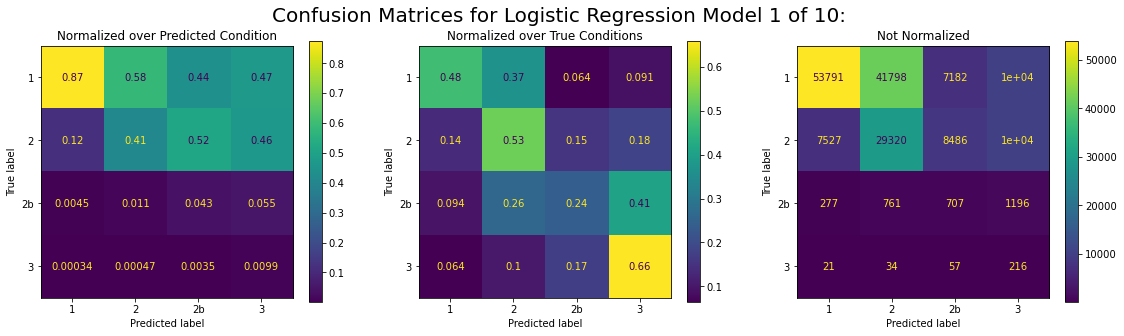

Logistic Regression Model 2 of 10:

              precision    recall  f1-score   support

           1   0.876948  0.463783  0.606704    113081
           2   0.404733  0.539381  0.462456     55521
          2b   0.042816  0.231214  0.072252      2941
           3   0.009778  0.661585  0.019271       328

    accuracy                       0.484602    171871
   macro avg   0.333569  0.473991  0.290171    171871
weighted avg   0.708476  0.484602  0.549840    171871



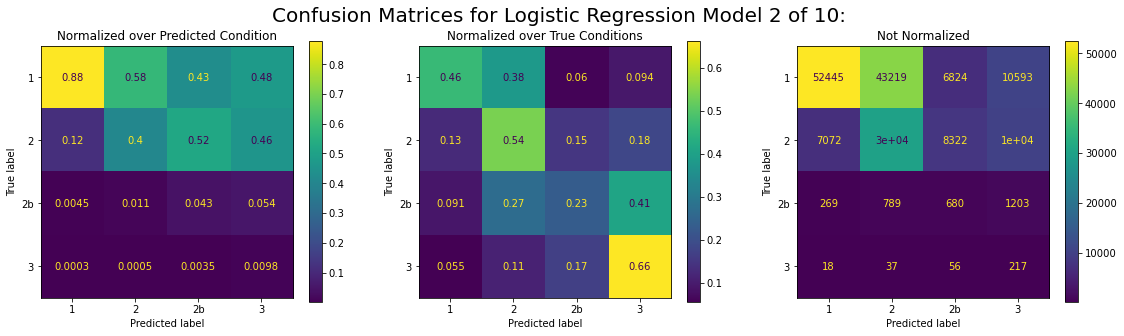

Logistic Regression Model 3 of 10:

              precision    recall  f1-score   support

           1   0.867725  0.482424  0.620097    113081
           2   0.410487  0.516471  0.457420     55521
          2b   0.042941  0.251615  0.073362      2941
           3   0.009629  0.643293  0.018974       328

    accuracy                       0.489780    171871
   macro avg   0.332696  0.473451  0.292463    171871
weighted avg   0.704268  0.489780  0.557043    171871



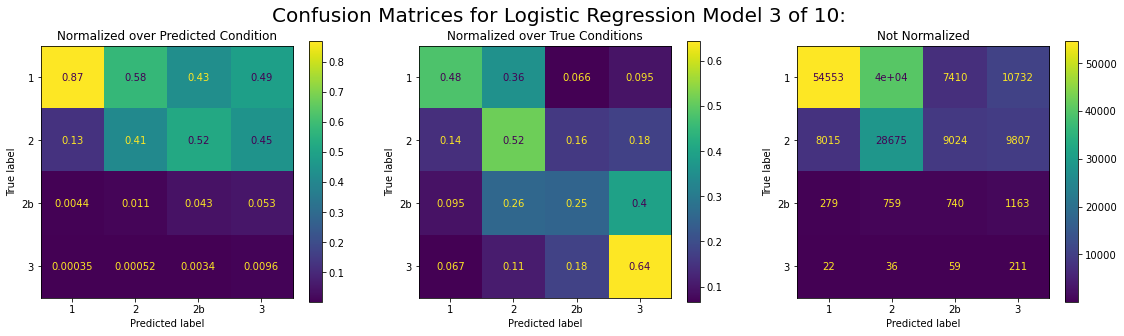

Logistic Regression Model 4 of 10:

              precision    recall  f1-score   support

           1   0.867191  0.481053  0.618827    113081
           2   0.410772  0.524576  0.460751     55521
          2b   0.043325  0.254335  0.074037      2941
           3   0.009965  0.637195  0.019623       328

    accuracy                       0.491531    171871
   macro avg   0.332813  0.474290  0.293310    171871
weighted avg   0.704016  0.491531  0.557297    171871



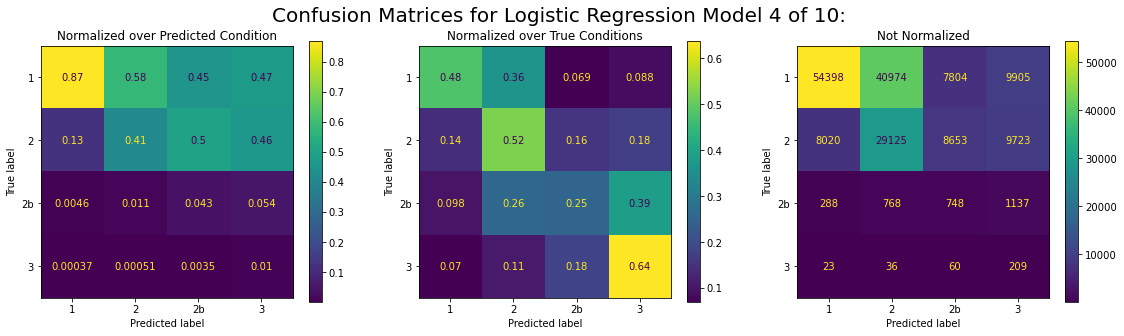

Logistic Regression Model 5 of 10:

              precision    recall  f1-score   support

           1   0.870742  0.477410  0.616697    113081
           2   0.409520  0.520344  0.458328     55521
          2b   0.041824  0.245155  0.071457      2941
           3   0.009735  0.655488  0.019184       328

    accuracy                       0.487645    171871
   macro avg   0.332955  0.474599  0.291417    171871
weighted avg   0.705922  0.487645  0.555068    171871



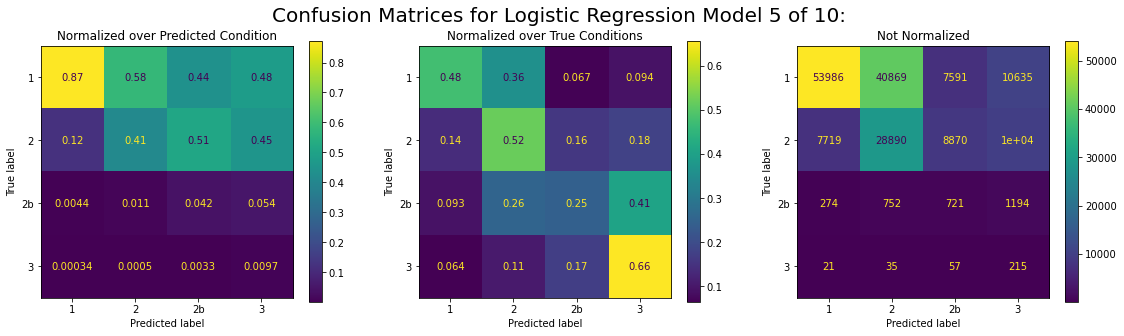

Logistic Regression Model 6 of 10:

              precision    recall  f1-score   support

           1   0.867364  0.487677  0.624326    113081
           2   0.411397  0.523766  0.460830     55521
          2b   0.045368  0.274056  0.077848      2941
           3   0.010081  0.609756  0.019834       328

    accuracy                       0.495913    171871
   macro avg   0.333552  0.473814  0.295710    171871
weighted avg   0.704367  0.495913  0.561006    171871



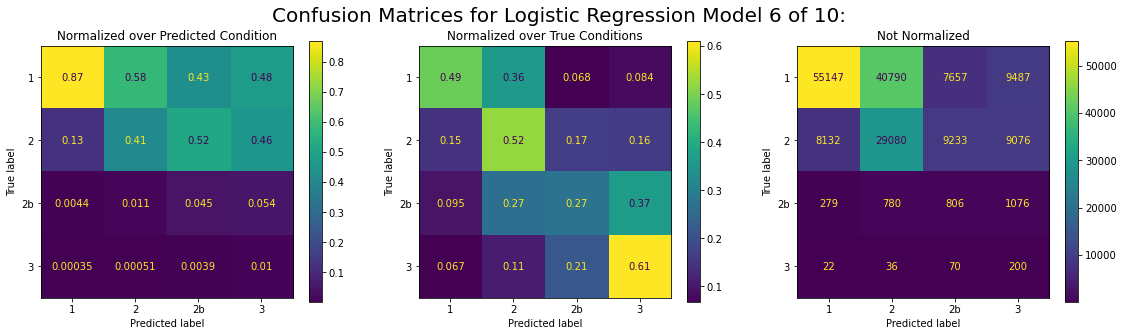

Logistic Regression Model 7 of 10:

              precision    recall  f1-score   support

           1   0.862951  0.490843  0.625757    113081
           2   0.414494  0.483655  0.446412     55521
          2b   0.039517  0.283577  0.069367      2941
           3   0.009556  0.631098  0.018828       328

    accuracy                       0.485242    171871
   macro avg   0.331630  0.472293  0.290091    171871
weighted avg   0.702363  0.485242  0.557143    171871



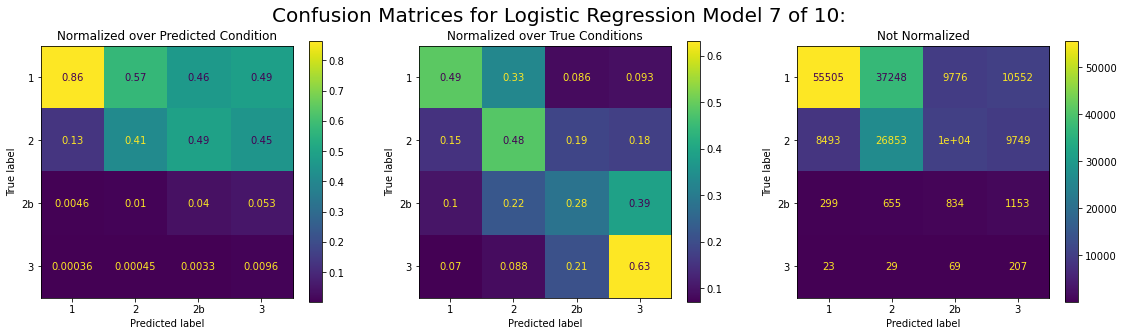

Logistic Regression Model 8 of 10:

              precision    recall  f1-score   support

           1   0.867534  0.478843  0.617082    113081
           2   0.408017  0.520470  0.457434     55521
          2b   0.041909  0.264196  0.072343      2941
           3   0.010203  0.625000  0.020078       328

    accuracy                       0.488896    171871
   macro avg   0.331916  0.472127  0.291734    171871
weighted avg   0.703328  0.488896  0.555049    171871



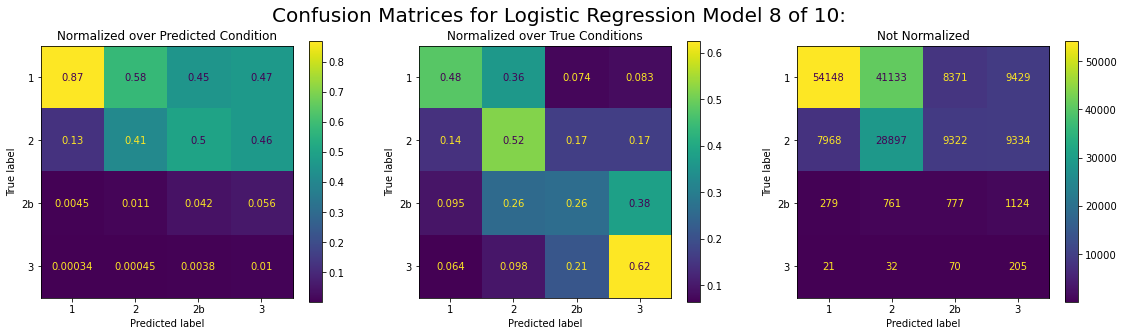

Logistic Regression Model 9 of 10:

              precision    recall  f1-score   support

           1   0.834926  0.551047  0.663914    113081
           2   0.419527  0.448263  0.433419     55521
          2b   0.045533  0.270656  0.077951      2941
           3   0.010229  0.637195  0.020135       328

    accuracy                       0.513210    171871
   macro avg   0.327553  0.476790  0.298855    171871
weighted avg   0.685654  0.513210  0.578200    171871



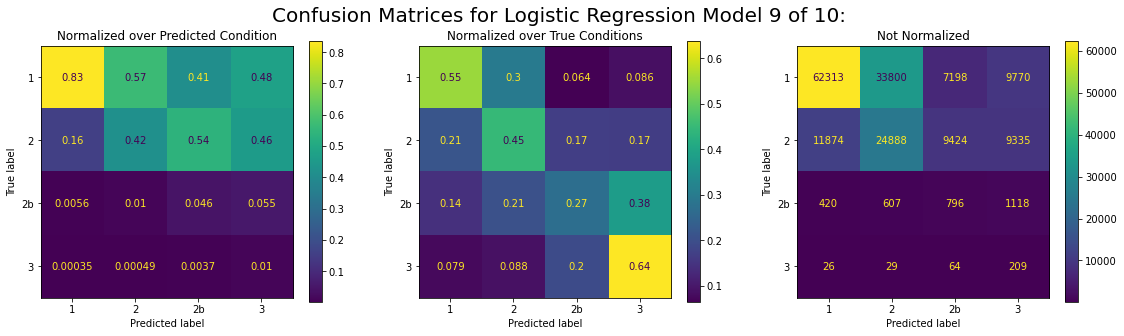

Logistic Regression Model 10 of 10:

              precision    recall  f1-score   support

           1   0.877623  0.472281  0.614095    113081
           2   0.406435  0.534915  0.461907     55521
          2b   0.046007  0.244475  0.077441      2941
           3   0.009633  0.655488  0.018988       328

    accuracy                       0.488966    171871
   macro avg   0.334925  0.476790  0.293108    171871
weighted avg   0.709524  0.488966  0.554614    171871



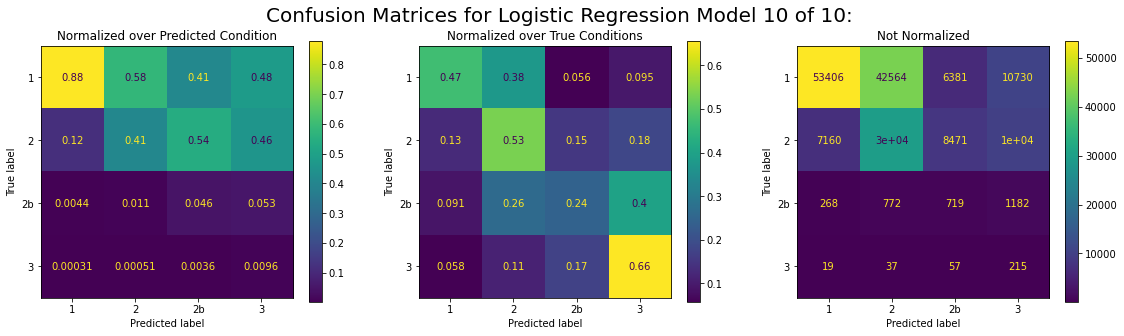

In [66]:
# For each logistic regression classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(logistic_regression_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, logistic_regression_clf in zip(range(len(logistic_regression_scores['estimator'])), logistic_regression_scores['estimator']):
    y_test_predicted = logistic_regression_clf.predict(X_test)
    logistic_regression_recall_score = recall_score(y_test, y_test_predicted, average='macro', labels=labels)
    print('Logistic Regression Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Logistic Regression Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [67]:
print_elapsed_time(notebook_start_time)

Elapsed time is 540.741655307007 seconds.


In [68]:
# Report statistics of the models built for each fold of the cross-validation.
for key in sorted(linear_svc_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(linear_svc_scores[key]), np.std(linear_svc_scores[key])), sep='')
        print('%s :%s' % (key, linear_svc_scores[key]), sep='')
        print()

fit_time: mean = 0.238959, std = 0.032695
fit_time :[0.2798667  0.24540901 0.29152894 0.25721598 0.21445894 0.1762054
 0.20730734 0.24147773 0.25089478 0.2252295 ]

score_time: mean = 0.058934, std = 0.012355
score_time :[0.04486895 0.05303168 0.07621694 0.056885   0.04523659 0.06016088
 0.04758835 0.05522394 0.06672287 0.08340168]

test_f1_macro: mean = 0.470951, std = 0.036214
test_f1_macro :[0.42765645 0.51554991 0.46436705 0.47001687 0.49088317 0.54852787
 0.44654921 0.42884191 0.45094574 0.4661703 ]

test_f1_weighted: mean = 0.470963, std = 0.036437
test_f1_weighted :[0.42759262 0.51543621 0.46537978 0.47059581 0.49128712 0.54887046
 0.44549743 0.42834733 0.45060653 0.46601305]

test_precision_macro: mean = 0.484963, std = 0.040389
test_precision_macro :[0.45173657 0.52180994 0.46746846 0.47082313 0.49659027 0.58513118
 0.44387379 0.48207112 0.44652567 0.48359546]

test_precision_weighted: mean = 0.484990, std = 0.040495
test_precision_weighted :[0.45191403 0.52189287 0.46818972 0

Support Vector Machine Model 1 of 10:

              precision    recall  f1-score   support

           1   0.881512  0.451782  0.597395    113081
           2   0.407499  0.532609  0.461729     55521
          2b   0.042313  0.205032  0.070149      2941
           3   0.008488  0.701220  0.016772       328

    accuracy                       0.474146    171871
   macro avg   0.334953  0.472661  0.286511    171871
weighted avg   0.712361  0.474146  0.543439    171871



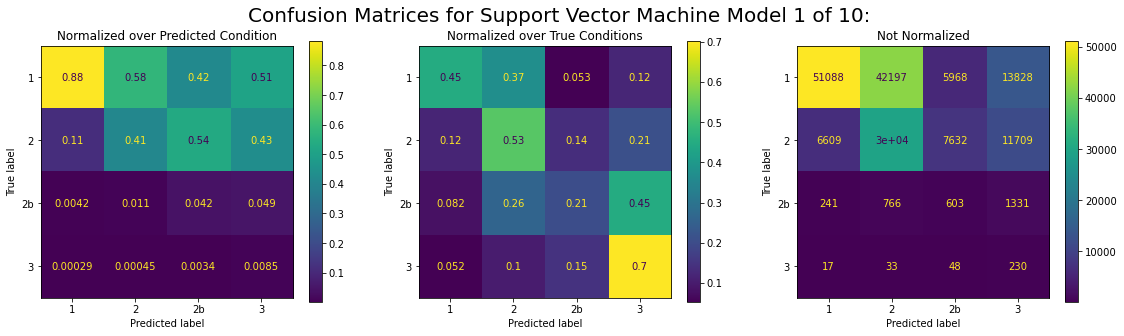

Support Vector Machine Model 2 of 10:

              precision    recall  f1-score   support

           1   0.863952  0.490312  0.625589    113081
           2   0.407798  0.510347  0.453345     55521
          2b   0.043466  0.212173  0.072151      2941
           3   0.009348  0.679878  0.018442       328

    accuracy                       0.492387    171871
   macro avg   0.331141  0.473178  0.292382    171871
weighted avg   0.700926  0.492387  0.559319    171871



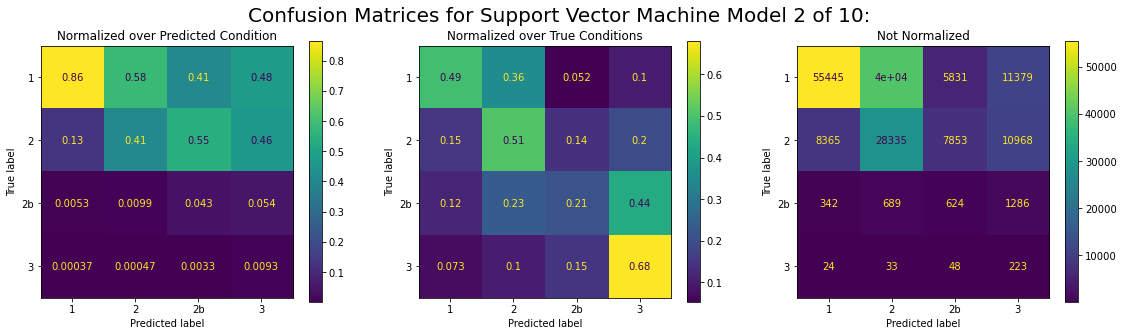

Support Vector Machine Model 3 of 10:

              precision    recall  f1-score   support

           1   0.866541  0.488632  0.624894    113081
           2   0.410821  0.514346  0.456791     55521
          2b   0.042776  0.213533  0.071275      2941
           3   0.009325  0.679878  0.018399       328

    accuracy                       0.492596    171871
   macro avg   0.332366  0.474097  0.292840    171871
weighted avg   0.703594  0.492596  0.559960    171871



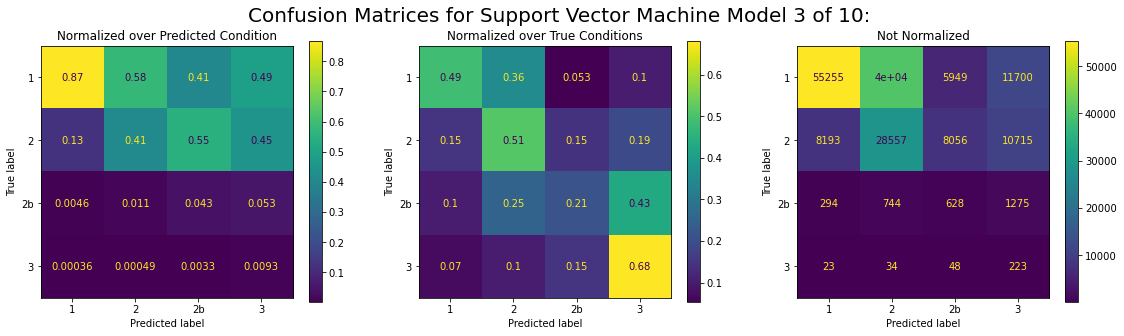

Support Vector Machine Model 4 of 10:

              precision    recall  f1-score   support

           1   0.833229  0.553347  0.665041    113081
           2   0.424729  0.450280  0.437132     55521
          2b   0.041771  0.216253  0.070017      2941
           3   0.009697  0.670732  0.019118       328

    accuracy                       0.514508    171871
   macro avg   0.327357  0.472653  0.297827    171871
weighted avg   0.686153  0.514508  0.580003    171871



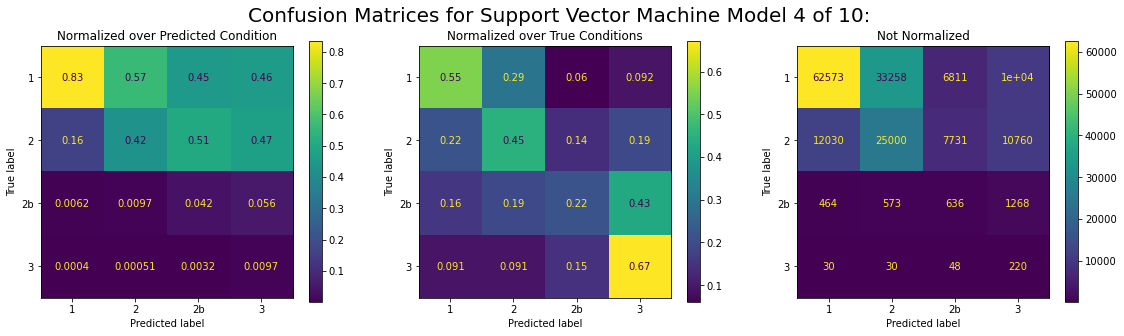

Support Vector Machine Model 5 of 10:

              precision    recall  f1-score   support

           1   0.874969  0.473236  0.614249    113081
           2   0.407498  0.521929  0.457669     55521
          2b   0.041876  0.224073  0.070564      2941
           3   0.009388  0.682927  0.018521       328

    accuracy                       0.485102    171871
   macro avg   0.333433  0.475541  0.290251    171871
weighted avg   0.708050  0.485102  0.553227    171871



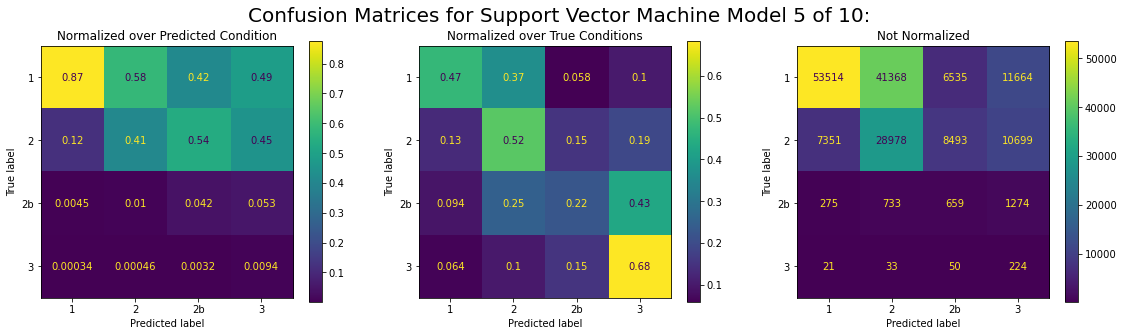

Support Vector Machine Model 6 of 10:

              precision    recall  f1-score   support

           1   0.870820  0.478515  0.617638    113081
           2   0.408845  0.527476  0.460646     55521
          2b   0.044414  0.210473  0.073350      2941
           3   0.009270  0.682927  0.018291       328

    accuracy                       0.490135    171871
   macro avg   0.333337  0.474848  0.292481    171871
weighted avg   0.705799  0.490135  0.556466    171871



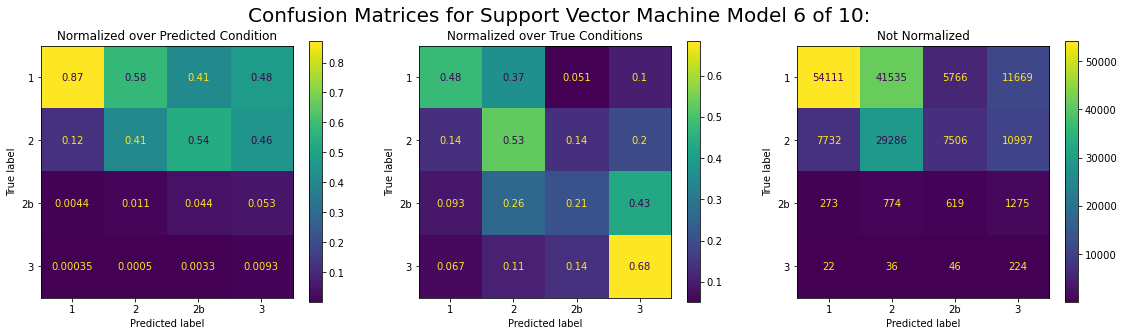

Support Vector Machine Model 7 of 10:

              precision    recall  f1-score   support

           1   0.860785  0.501296  0.633601    113081
           2   0.416362  0.478306  0.445190     55521
          2b   0.038402  0.244135  0.066365      2941
           3   0.009644  0.692073  0.019023       328

    accuracy                       0.489832    171871
   macro avg   0.331298  0.478952  0.291044    171871
weighted avg   0.701523  0.489832  0.561857    171871



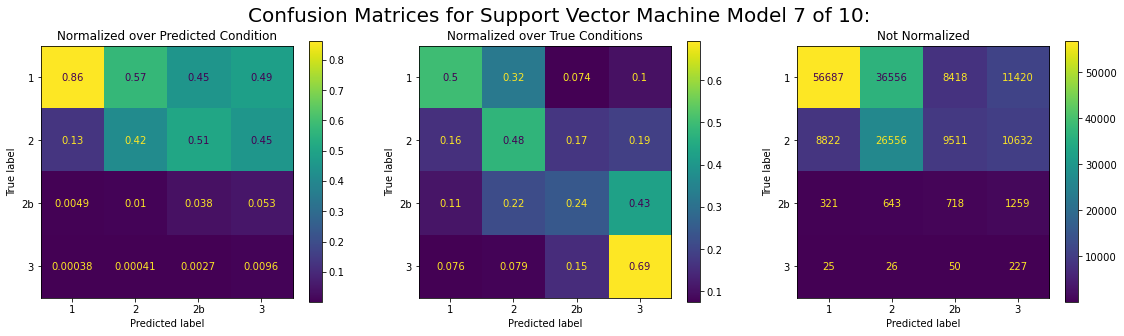

Support Vector Machine Model 8 of 10:

              precision    recall  f1-score   support

           1   0.872302  0.480302  0.619499    113081
           2   0.408169  0.530970  0.461541     55521
          2b   0.041169  0.212173  0.068958      2941
           3   0.009989  0.676829  0.019687       328

    accuracy                       0.492457    171871
   macro avg   0.332907  0.475068  0.292421    171871
weighted avg   0.706501  0.492457  0.557907    171871



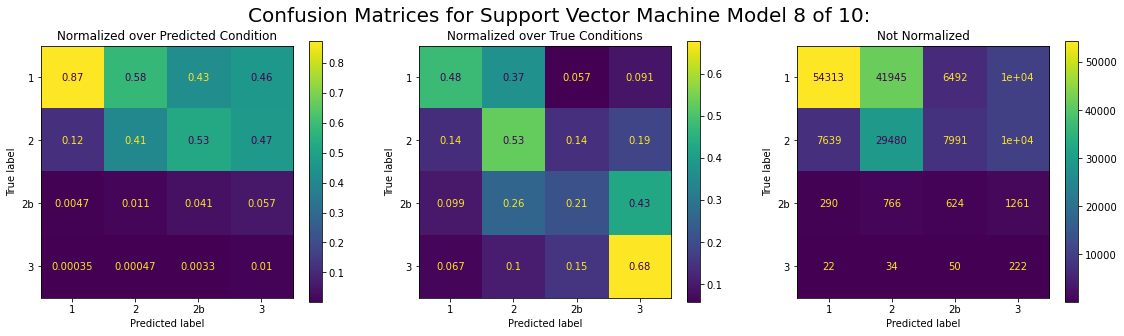

Support Vector Machine Model 9 of 10:

              precision    recall  f1-score   support

           1   0.829852  0.559705  0.668519    113081
           2   0.424104  0.437510  0.430703     55521
          2b   0.043373  0.206392  0.071682      2941
           3   0.009330  0.692073  0.018411       328

    accuracy                       0.514438    171871
   macro avg   0.326665  0.473920  0.297329    171871
weighted avg   0.683756  0.514438  0.580241    171871



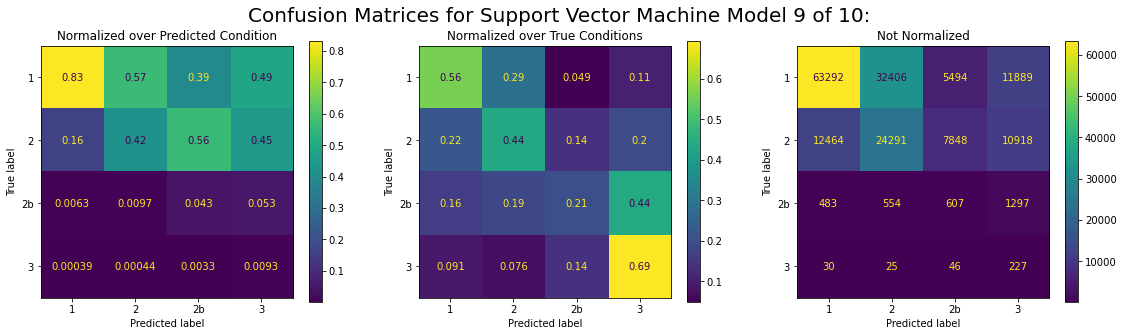

Support Vector Machine Model 10 of 10:

              precision    recall  f1-score   support

           1   0.879672  0.467674  0.610681    113081
           2   0.405636  0.538787  0.462825     55521
          2b   0.045179  0.225434  0.075272      2941
           3   0.009387  0.667683  0.018513       328

    accuracy                       0.486883    171871
   macro avg   0.334968  0.474894  0.291823    171871
weighted avg   0.710599  0.486883  0.552626    171871



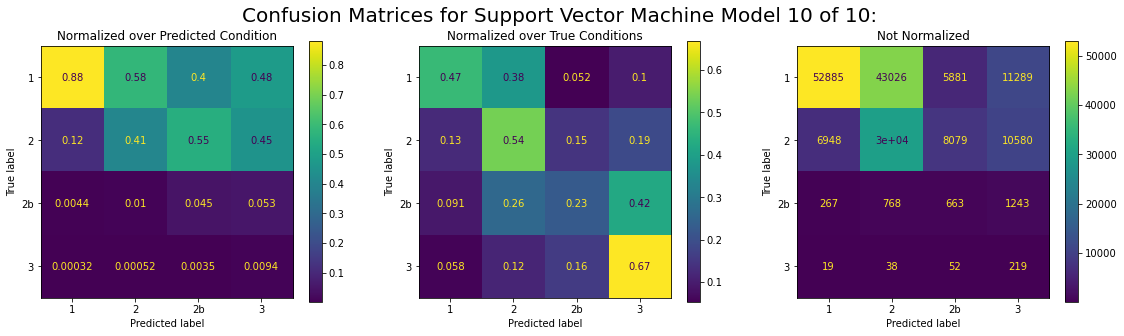

In [69]:
# For each support vector machine classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(linear_svc_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, linear_svc_clf in zip(range(len(linear_svc_scores['estimator'])), linear_svc_scores['estimator']):
    y_test_predicted = linear_svc_clf.predict(X_test)
    linear_svc_recall_score = recall_score(y_test, y_test_predicted, average='macro', labels=labels)
    print('Support Vector Machine Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Support Vector Machine Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1,3,1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1,3,2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1,3,3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)
    
    plt.show()

In [70]:
# Report statistics of the models built for each fold of the cross-validation.
for key in sorted(k_neighbors_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(k_neighbors_scores[key]), np.std(k_neighbors_scores[key])), sep='')
        print('%s :%s' % (key, k_neighbors_scores[key]), sep='')
        print()

fit_time: mean = 0.039443, std = 0.019160
fit_time :[0.03881001 0.02354002 0.06575131 0.07023549 0.05619407 0.02860093
 0.01965618 0.02013707 0.05289531 0.01861143]

score_time: mean = 0.618160, std = 0.100687
score_time :[0.63171983 0.70028234 0.73514962 0.8030107  0.59506011 0.53453612
 0.62967777 0.51575184 0.58327079 0.45314479]

test_f1_macro: mean = 0.485300, std = 0.039935
test_f1_macro :[0.47720129 0.53690331 0.46118143 0.46493887 0.50313356 0.56816326
 0.44939501 0.4394057  0.50356651 0.44910948]

test_f1_weighted: mean = 0.485344, std = 0.040082
test_f1_weighted :[0.47754023 0.53705883 0.46188088 0.46555884 0.5033568  0.56836017
 0.44834346 0.43872423 0.50338594 0.44922617]

test_neg_log_loss: mean = -4.040818, std = 0.557369
test_neg_log_loss :[-4.38242671 -4.21553177 -3.63806652 -3.53017436 -4.12212377 -3.7939512
 -4.96303108 -4.09974132 -2.95768465 -4.70544477]

test_precision_macro: mean = 0.488281, std = 0.044508
test_precision_macro :[0.48175364 0.53727453 0.4642335  0.

k-Nearest Neighbor Model 1 of 10:

              precision    recall  f1-score   support

           1   0.806828  0.564896  0.664527    113081
           2   0.403240  0.437600  0.419718     55521
          2b   0.055592  0.284597  0.093016      2941
           3   0.012881  0.682927  0.025285       328

    accuracy                       0.519203    171871
   macro avg   0.319635  0.492505  0.300636    171871
weighted avg   0.662083  0.519203  0.574445    171871



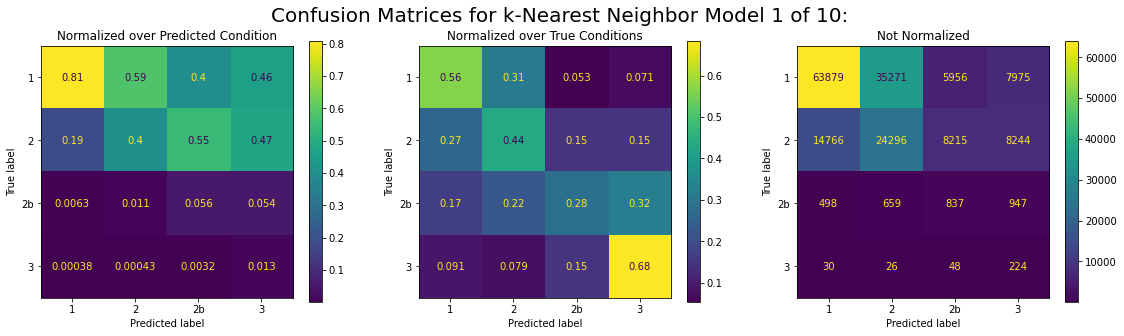

k-Nearest Neighbor Model 2 of 10:

              precision    recall  f1-score   support

           1   0.813932  0.560872  0.664112    113081
           2   0.409978  0.425064  0.417385     55521
          2b   0.048197  0.310439  0.083440      2941
           3   0.012958  0.689024  0.025438       328

    accuracy                       0.512960    171871
   macro avg   0.321266  0.496350  0.297594    171871
weighted avg   0.668808  0.512960  0.573254    171871



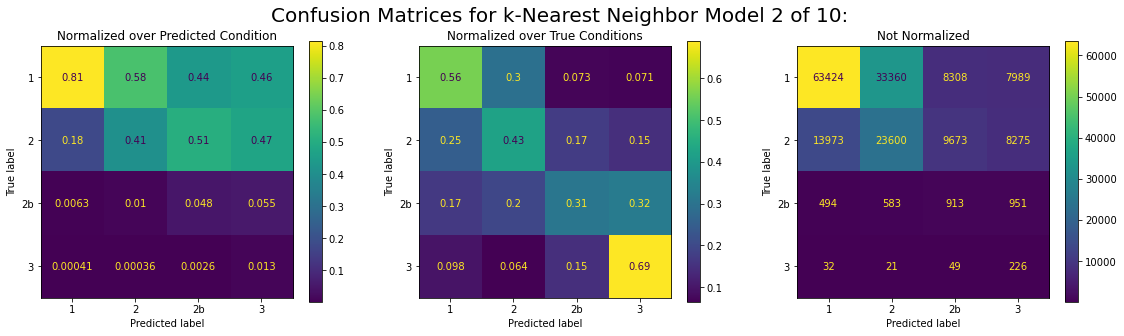

k-Nearest Neighbor Model 3 of 10:

              precision    recall  f1-score   support

           1   0.803350  0.578921  0.672916    113081
           2   0.409449  0.428018  0.418528     55521
          2b   0.057833  0.281537  0.095955      2941
           3   0.012427  0.682927  0.024410       328

    accuracy                       0.525283    171871
   macro avg   0.320765  0.492851  0.302952    171871
weighted avg   0.661838  0.525283  0.579629    171871



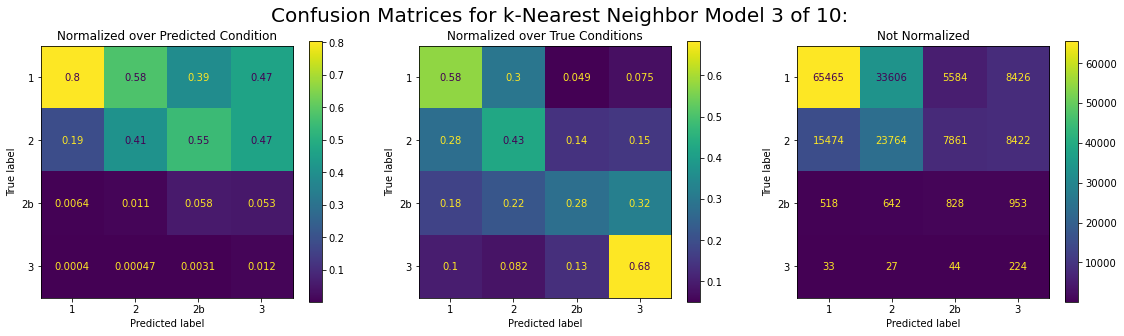

k-Nearest Neighbor Model 4 of 10:

              precision    recall  f1-score   support

           1   0.803138  0.572156  0.668250    113081
           2   0.408009  0.410890  0.409444     55521
          2b   0.048186  0.326420  0.083975      2941
           3   0.014086  0.664634  0.027588       328

    accuracy                       0.516032    171871
   macro avg   0.318355  0.493525  0.297314    171871
weighted avg   0.661072  0.516032  0.573425    171871



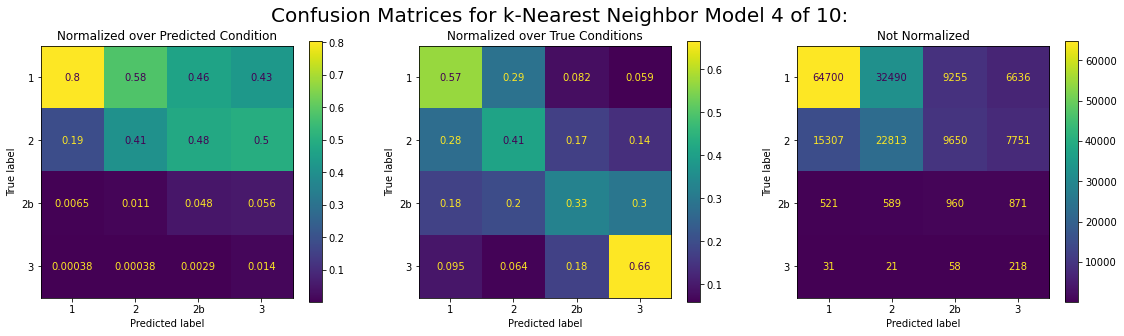

k-Nearest Neighbor Model 5 of 10:

              precision    recall  f1-score   support

           1   0.810467  0.558900  0.661576    113081
           2   0.404553  0.444877  0.423758     55521
          2b   0.057334  0.286297  0.095535      2941
           3   0.012728  0.704268  0.025004       328

    accuracy                       0.517679    171871
   macro avg   0.321270  0.498586  0.301468    171871
weighted avg   0.664931  0.517679  0.573851    171871



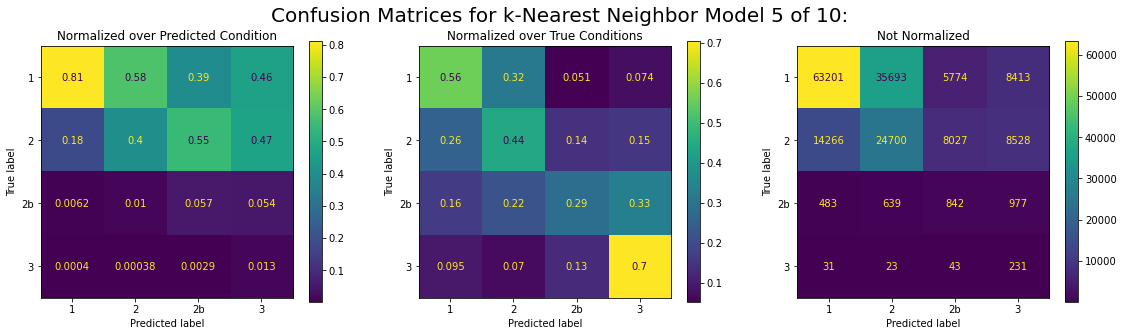

k-Nearest Neighbor Model 6 of 10:

              precision    recall  f1-score   support

           1   0.806044  0.565886  0.664945    113081
           2   0.403838  0.427586  0.415373     55521
          2b   0.053896  0.285277  0.090663      2941
           3   0.012687  0.701220  0.024923       328

    accuracy                       0.516667    171871
   macro avg   0.319116  0.494992  0.298976    171871
weighted avg   0.661731  0.516667  0.573275    171871



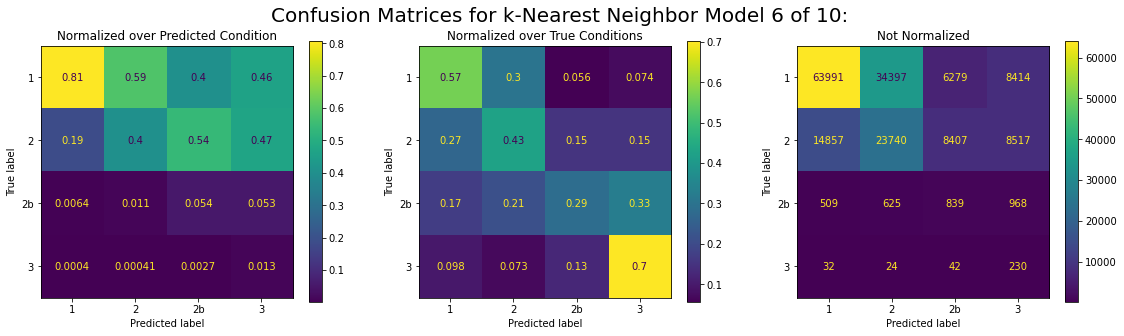

k-Nearest Neighbor Model 7 of 10:

              precision    recall  f1-score   support

           1   0.802297  0.571962  0.667827    113081
           2   0.407477  0.396373  0.401848     55521
          2b   0.047583  0.317239  0.082753      2941
           3   0.012926  0.695122  0.025380       328

    accuracy                       0.511116    171871
   macro avg   0.317571  0.495174  0.294452    171871
weighted avg   0.660334  0.511116  0.570668    171871



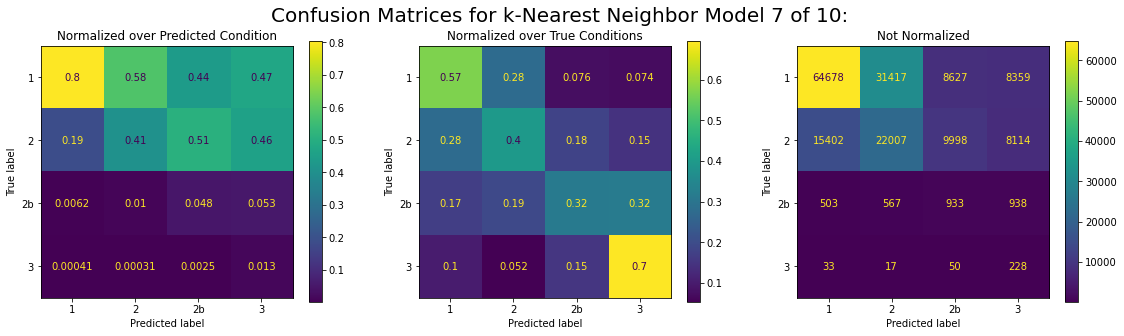

k-Nearest Neighbor Model 8 of 10:

              precision    recall  f1-score   support

           1   0.795363  0.591868  0.678690    113081
           2   0.404367  0.400587  0.402468     55521
          2b   0.052270  0.313159  0.089587      2941
           3   0.014371  0.661585  0.028131       328

    accuracy                       0.525441    171871
   macro avg   0.316593  0.491800  0.299719    171871
weighted avg   0.654850  0.525441  0.578138    171871



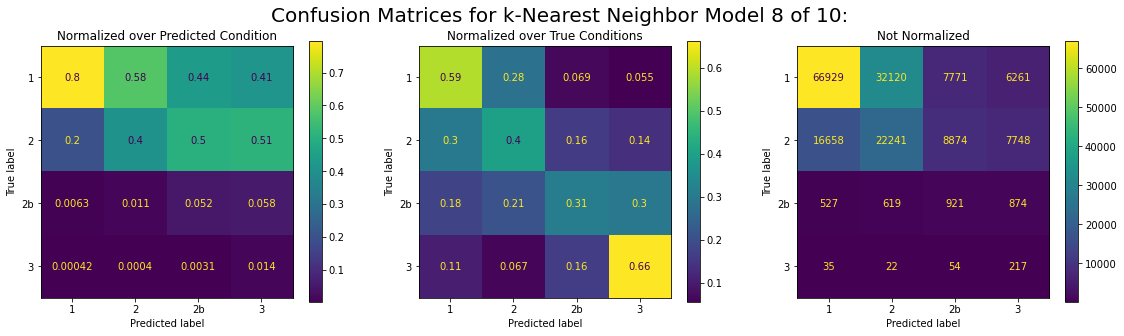

k-Nearest Neighbor Model 9 of 10:

              precision    recall  f1-score   support

           1   0.803586  0.573058  0.669021    113081
           2   0.406697  0.420688  0.413574     55521
          2b   0.055100  0.317919  0.093923      2941
           3   0.012834  0.658537  0.025178       328

    accuracy                       0.519634    171871
   macro avg   0.319554  0.492550  0.300424    171871
weighted avg   0.661059  0.519634  0.575432    171871



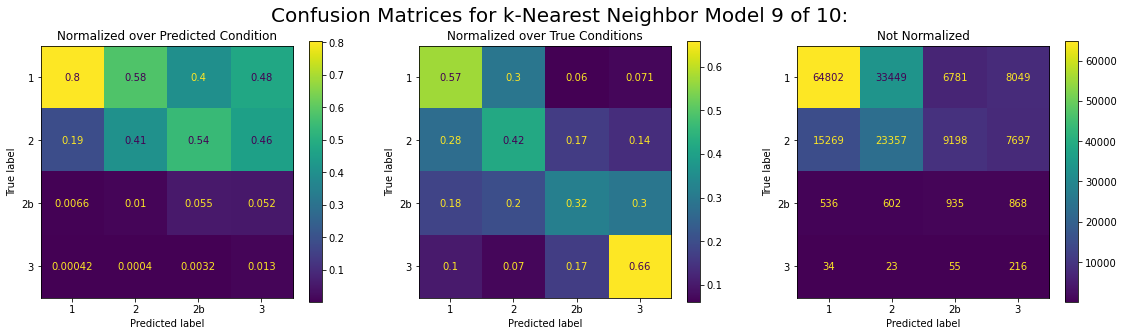

k-Nearest Neighbor Model 10 of 10:

              precision    recall  f1-score   support

           1   0.797543  0.579956  0.671565    113081
           2   0.401410  0.404063  0.402732     55521
          2b   0.054255  0.290037  0.091411      2941
           3   0.012811  0.704268  0.025165       328

    accuracy                       0.518412    171871
   macro avg   0.316505  0.494581  0.297718    171871
weighted avg   0.655360  0.518412  0.573560    171871



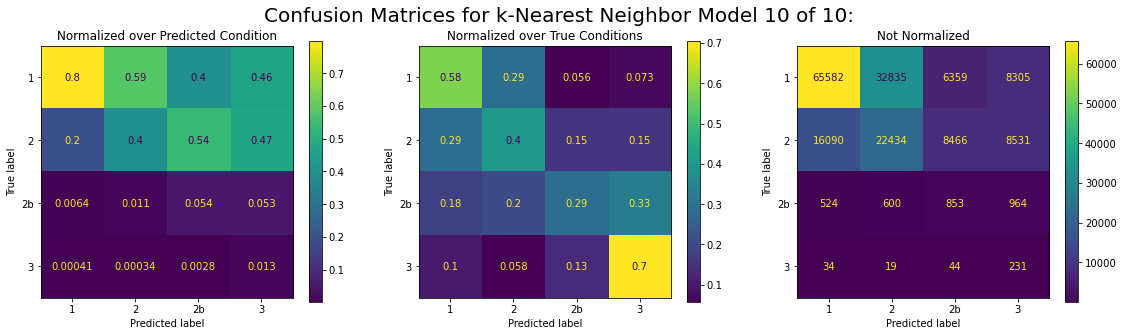

In [71]:
# For each k-Nearest Neighbor classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(k_neighbors_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, knn_clf in zip(range(len(k_neighbors_scores['estimator'])), k_neighbors_scores['estimator']):
    y_test_predicted = knn_clf.predict(X_test)
    knn_recall_score = recall_score(y_test, y_test_predicted, average='macro', labels=labels)
    print('k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [72]:
print('Reports and graphics generated in %f seconds' % (elapsed_time(t0)))

Reports and graphics generated in 5333.272099 seconds


In [73]:
print_elapsed_time(notebook_start_time)

Elapsed time is 5549.424025821965 seconds.
